# Data Encoding

In the following notebook, we follow the IBM Course `Quantum Machine Learning`, and in particular discuss several ways of data encoding in quantum machine learning.

## Basis encoding

Basis encoding encodes classical P-bit strings into the computational state of a P-qubit system. As an example, let's encode the vector (5,7,0). The binary strings are given by
* 5 $\to$ 0101
* 7 $\to$ 0111
* 0 $\to$ 0000

and its 12-qubit quantum state is given by $|010101110000\rangle$. The code below converts the data vector (5,7,0) to a quantum state, and is generalized to do so for other single-digit features.

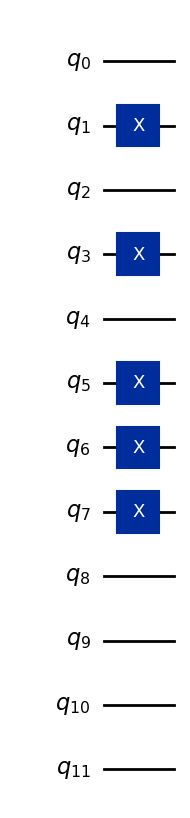

In [1]:
from qiskit import QuantumCircuit
 
# Data point to encode
x = 5  # binary: 0101
y = 7  # binary: 0111
z = 0  # binary: 0000
 
# Convert each to 4-bit binary list
x_bits = [int(b) for b in format(x, "04b")]  # [0,1,0,1]
y_bits = [int(b) for b in format(y, "04b")]  # [0,1,1,1]
z_bits = [int(b) for b in format(z, "04b")]  # [0,0,0,0]
 
# Combine all bits
all_bits = x_bits + y_bits + z_bits  # [0,1,0,1,0,1,1,1,0,0,0,0]
 
# Initialize a 12-qubit quantum circuit
qc = QuantumCircuit(12)
 
# Apply x-gates where the bit is 1
for idx, bit in enumerate(all_bits):
    if bit == 1:
        qc.x(idx)
 
qc.draw("mpl")

For the vector (4,8,5) this would be

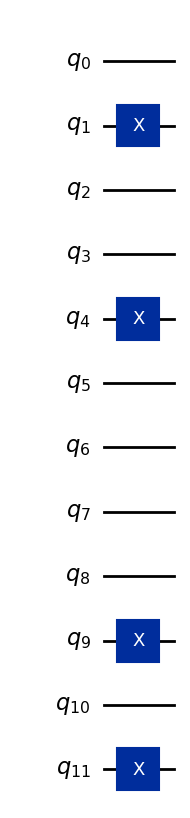

In [2]:
# Data point to encode
x = 4  # binary: 0100
y = 8  # binary: 1000
z = 5  # binary: 0101
 
# Convert each to 4-bit binary list
x_bits = [int(b) for b in format(x, "04b")]  # [0,1,0,0]
y_bits = [int(b) for b in format(y, "04b")]  # [1,0,0,0]
z_bits = [int(b) for b in format(z, "04b")]  # [0,1,0,1]
 
# Combine all bits
all_bits = x_bits + y_bits + z_bits  # [0,1,0,0,1,0,0,0,0,1,0,1]
 
# Initialize a 12-qubit quantum circuit
qc = QuantumCircuit(12)
 
# Apply x-gates where the bit is 1
for idx, bit in enumerate(all_bits):
    if bit == 1:
        qc.x(idx)
 
qc.draw("mpl")

## Amplitude encoding

Another method is amplitude encoding, where an N-dimensional data vector $\vec{x}^{(j)}$ is encoded as an amplitude of a n-qubit quantum state $|\psi_x\rangle$ as
\begin{equation}
|\psi_x^{(j)}\rangle = \frac{1}{\alpha}\sum_{i=1}^{N} x_i^{(j)}|i\rangle
\end{equation}
where $x_i^{(j)}$ is the $i^{\rm th}$ element of $\vec{x}^{(j)}$, $|i\rangle$ is the $i^{\rm th}$ computational basis state, $\alpha$ the normalization calculated by $\sum_{i=1}^N |x_i^{(j)}|^2=\alpha^2$. We need $n \geq \log_2(N)$ qubits for $|i\rangle$.

Let's look at the example $\vec{x}^{(1)}=(4,8,5)$ which becomes
\begin{equation}
|\psi (\vec{x}^{(1)}\rangle = \frac{1}{\sqrt{105}} (4|00\rangle + 8 |01\rangle +5|10\rangle +0 |11\rangle)
\end{equation}

In Qiskit this state can be prepared as:

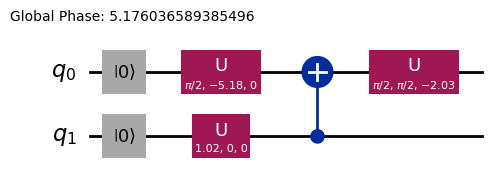

In [3]:
import math
 
desired_state = [
    1 / math.sqrt(105) * 4,
    1 / math.sqrt(105) * 8,
    1 / math.sqrt(105) * 5,
    1 / math.sqrt(105) * 0,
]
 
qc = QuantumCircuit(2)
qc.initialize(desired_state, [0, 1])
 
qc.decompose(reps=5).draw(output="mpl")

As a second example, we look at $\vec{x}=(9,8,6,2,9,2)$. The normalization is $\alpha=\sqrt{270}$ and $n\geq \log_2(6) \approx 2.58$, so we need $n=3$ qubits. Hence, we get
\begin{equation}
|\psi(\vec{x})\rangle = \frac{1}{\sqrt{270}}(9|000\rangle + 8 |001\rangle + 6|010\rangle + 2|011\rangle + 9 |100\rangle + 2|101\rangle + 0 |110\rangle + 0|111\rangle)
\end{equation}

The coded version would be

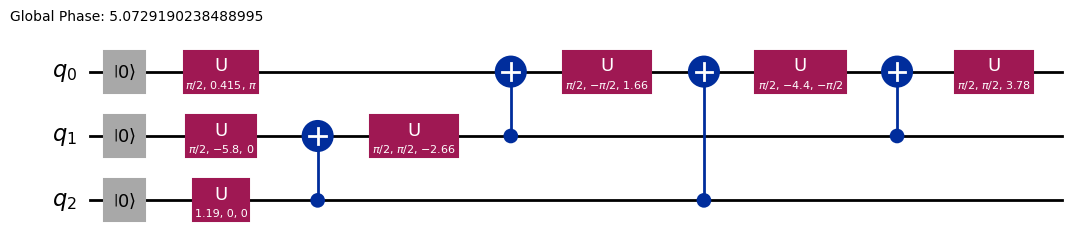

In [4]:
desired_state = [
    1 / math.sqrt(270) * 9,
    1 / math.sqrt(270) * 8,
    1 / math.sqrt(270) * 6,
    1 / math.sqrt(270) * 2,
    1 / math.sqrt(270) * 9,
    1 / math.sqrt(270) * 2,
    1 / math.sqrt(270) * 0,
    1 / math.sqrt(270) * 0,
]
 
qc = QuantumCircuit(3)
qc.initialize(desired_state, [0, 1, 2])
 
qc.decompose(reps=8).draw(output="mpl")

While this case was still possible by hand, we would like to automate the process of amplitude encoding. In the following, we will write some functions to automatically initialize amplitude encoded states.

In [5]:
def norm(vec):
    alpha = sum([i**2 for i in vec])
    return math.sqrt(alpha)

def calc_n(vec):
    nr_entries = len(vec)
    n = math.ceil(math.log(nr_entries, 2))
    return n

def desired_state(vec):
    fac = 1/norm(vec)
    state = [fac*i for i in vec]
    nr_basis_states = 2**calc_n(vec)
    if len(state)<nr_basis_states:
        for ix in range(len(state),nr_basis_states):
            state.append(0)
    return state

def run_encoding(vector,reps):
    state = desired_state(vector)
    n = calc_n(vector)
    q_list = list(range(n))
    
    qc = QuantumCircuit(n)
    qc.initialize(state, q_list)
 
    return qc.decompose(reps=reps).draw(output="mpl")

As an example, let's take $\vec{x}=(4,8,5,9,8,6,2,9,2,5,7,0,3,7,5)$:

4


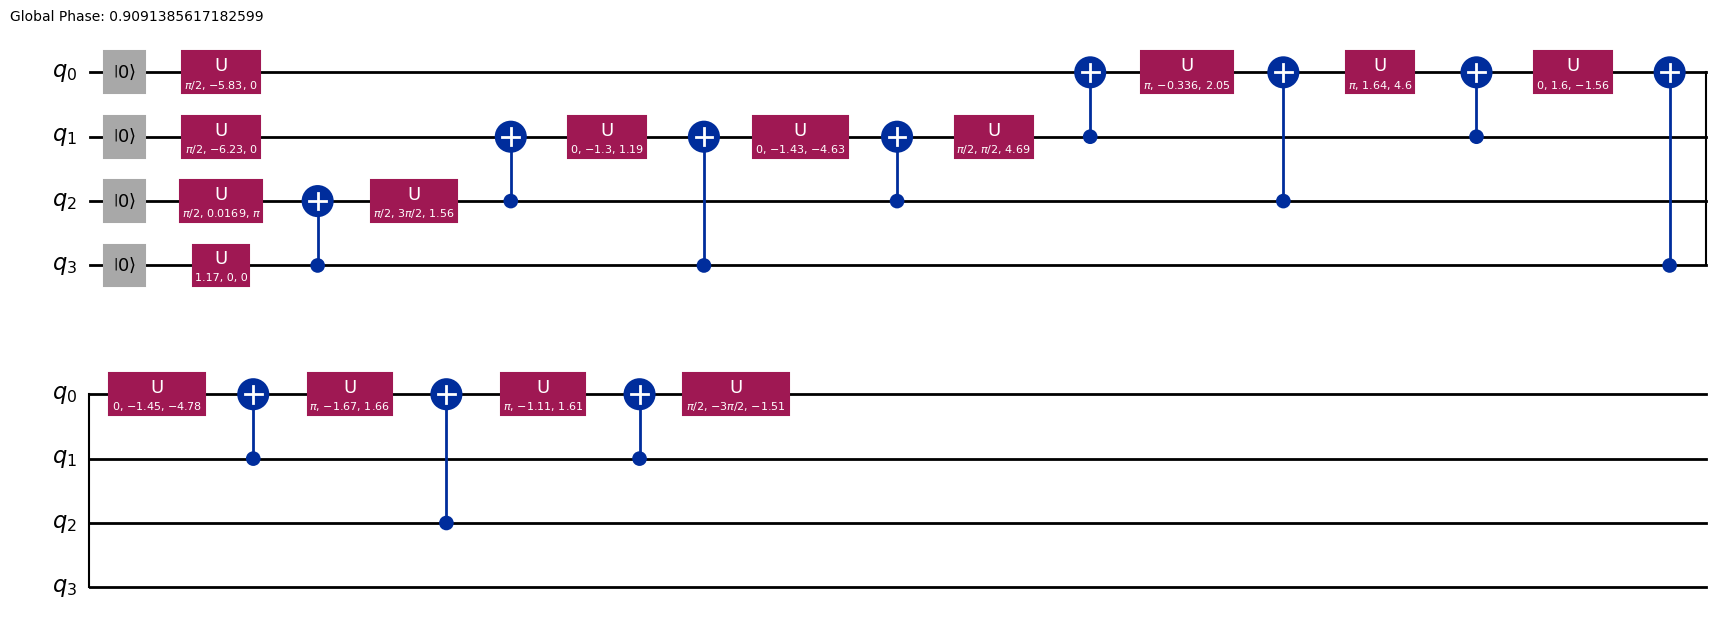

In [6]:
vector = [4,8,5,9,8,6,2,9,2,5,7,0,3,7,5]

print(calc_n(vector))
state = desired_state(vector)

run_encoding(state,16)

## Angle encoding

Angle encoding is particularly interesting for QML models using Pauli feature maps, such as QSVMs or VQCs. It is closely related to phase encoding and dense angle encoding, which will be discussed below. Angle encoding is a rotation in $\theta$ (rotation away from the z axis) by a $R_x$ or $R_y$ gate. Most commonly is the $R_y$ which will use in the following. As an example, let's encode a single ($k^{\rm th}$ feature from the $j^{\rm th}$ data vector in a dataset $\vec{x}^{(j)}_k:
\begin{equation}
|\vec{x}^{(j)}_k\rangle R_y(\theta = \vec{x}_k^{(j)})|0\rangle = \cos(\frac{\vec{x}_k^{(j)}}{2})|0\rangle + \sin(\frac{\vec{x}_k^{(j)}}{2})|1\rangle
\end{equation}

Some characteristics of angle encoding are:
* each feature is mapped to a corresponding qubit $\vec{x}_k^{(j)}\to Q_k$ and the qubit is in a product state
* one numerical value encoded at a time, rather than a whole set of features from a data point
* $n$ qubits required for N data features, where $n\leq N$ (with $=$ being most common)
* resulting circuit is a constant depth (typ. depth is 1 prior to transpilation) ??
* with $R_y$, we create real-valued quantum states

Advice: First rescale data to $\vec{x}_k^{(j)}\in (0,2\pi]$, preventing information loss and unwanted effects

In the following, we rotate $|0\rangle$ to encode $\vec{x}_k^{(j)}=\frac12 \pi$

In [7]:
from qiskit.quantum_info import Statevector
from math import pi
 
qc = QuantumCircuit(1)
state1 = Statevector.from_instruction(qc)
qc.ry(pi / 2, 0)  # Phase gate rotates by an angle pi/2
state2 = Statevector.from_instruction(qc)
states = state1, state2

We visualise the encoding procedure with the following code that is projecting the encoding onto the Bloch sphere

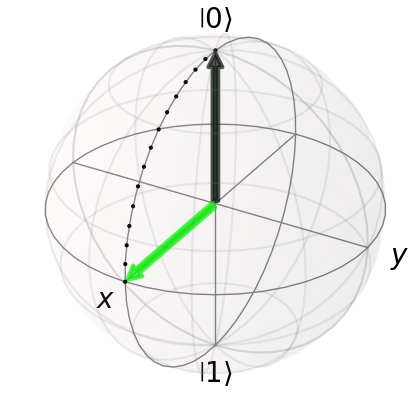

In [8]:
import numpy as np
from qiskit.visualization.bloch import Bloch
from qiskit.visualization.state_visualization import _bloch_multivector_data
 
 
def plot_Nstates(states, axis, plot_trace_points=True):
    """This function plots N states to 1 Bloch sphere"""
    bloch_vecs = [_bloch_multivector_data(s)[0] for s in states]
 
    if axis is None:
        bloch_plot = Bloch()
    else:
        bloch_plot = Bloch(axes=axis)
 
    bloch_plot.add_vectors(bloch_vecs)
 
    if len(states) > 1:
 
        def rgba_map(x, num):
            g = (0.95 - 0.05) / (num - 1)
            i = 0.95 - g * num
            y = g * x + i
            return (0.0, y, 0.0, 0.7)
 
        num = len(states)
        bloch_plot.vector_color = [rgba_map(x, num) for x in range(1, num + 1)]
 
    bloch_plot.vector_width = 3
    bloch_plot.vector_style = "simple"
 
    if plot_trace_points:
 
        def trace_points(bloch_vec1, bloch_vec2):
            # bloch_vec = (x,y,z)
            n_points = 15
            thetas = np.arccos([bloch_vec1[2], bloch_vec2[2]])
            phis = np.arctan2(
                [bloch_vec1[1], bloch_vec2[1]], [bloch_vec1[0], bloch_vec2[0]]
            )
            if phis[1] < 0:
                phis[1] = phis[1] + 2 * pi
            angles0 = np.linspace(phis[0], phis[1], n_points)
            angles1 = np.linspace(thetas[0], thetas[1], n_points)
 
            xp = np.cos(angles0) * np.sin(angles1)
            yp = np.sin(angles0) * np.sin(angles1)
            zp = np.cos(angles1)
            pnts = [xp, yp, zp]
            bloch_plot.add_points(pnts)
            bloch_plot.point_color = "k"
            bloch_plot.point_size = [4] * len(bloch_plot.points)
            bloch_plot.point_marker = ["o"]
 
        for i in range(len(bloch_vecs) - 1):
            trace_points(bloch_vecs[i], bloch_vecs[i + 1])
 
    bloch_plot.sphere_alpha = 0.05
    bloch_plot.frame_alpha = 0.15
    bloch_plot.figsize = [4, 4]
 
    bloch_plot.render()
 
 
plot_Nstates(states, axis=None, plot_trace_points=True)

If we extend angle encoding to encoding N features into the rotation angles of n qubits, e.g. for $\vec{x}^{(j)} = (x_1,...,x_N)$, the encoded product state looks like
\begin{align}
|\vec{x}^{(j)}\rangle &= \otimes_{k=1}^N \cos(\vec{x}^{(j)}_k)|0\rangle + \sin(\vec{x}^{(j)}_k)|1\rangle\\
&=\otimes_{k=1}^N R_y(2\vec{x}^{(j)}_k)|0\rangle
\end{align}

In Qiskit, we would write for a state $\vec{x}=(0,\pi/2,\pi/4)$

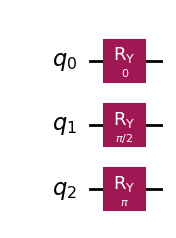

In [9]:
qc = QuantumCircuit(3)
qc.ry(0, 0)
qc.ry(2 * math.pi / 4, 1)
qc.ry(2 * math.pi / 2, 2)
qc.draw(output="mpl")

In [10]:
psi = Statevector(qc)
psi.draw("latex")

<IPython.core.display.Latex object>

## Phase encoding

The phase angle for phase encoding is a real-valued angle about the z-axis from the +x-axis. The phase rotation is given by $P(\phi)=e^{i\phi/2}R_z(\phi)$. Some characteristics are:
* data should be rescaled to $\vec{x}^{(j)}_k\in (0,2\pi]$ to avoid information loss and unwanted effects
* In practise, a state is initialized using a Hadamard gate, followed by the phase encoding:
\begin{equation}
|\vec{x}^{(j)}_k\rangle = P(\phi=\vec{x}^{(j)}_k)|+\rangle = \frac{1}{\sqrt{2}} (|0\rangle + e^{i\vec{x}^{(j)}_k}|1\rangle)
\end{equation}
* phase encoding maps $\vec{x}^{(j)}_k$ features to $Q_k$ qubit, resulting in n qubits for N=n features. The phase encoded multi-qubit state is a product state of the form
\begin{equation}
|\vec{x}^{(j)}\rangle = \otimes_{k=1}^N P_k(\phi=\vec{x}^{(j)}_k)|+\rangle^{\otimes N}=\frac{1}{\sqrt{2^N}}\otimes_{k=1}^N (|0\rangle + e^{i\vec{x}^{(j)}_k}|1\rangle)
\end{equation}

In Qiskit, we implement $\vec{x}^{(j)}_k=\pi/2$ as

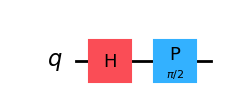

In [11]:
qc = QuantumCircuit(1)
qc.h(0)  # Hadamard gate rotates state down to Bloch equator
state1 = Statevector.from_instruction(qc)
 
qc.p(pi / 2, 0)  # Phase gate rotates by an angle pi/2
state2 = Statevector.from_instruction(qc)
 
states = state1, state2
 
qc.draw("mpl", scale=1)

which can be visualised as before with

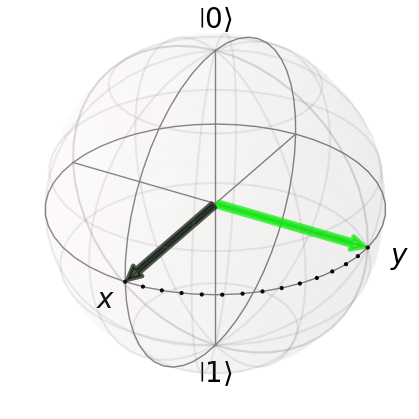

In [12]:
plot_Nstates(states, axis=None, plot_trace_points=True)

For the vector $\vec{x}=(4,8,5,9,8,6,2,9,2,5,7,0), we would automize the code a bit more to

In [13]:
def rescale_vec(vec):
    v_min = np.min(vec)
    v_max = np.max(vec)

    # Avoid division by zero if all values are the same
    if v_min == v_max: return np.full_like(vector, math.pi) 
    
    # Map to [0, 2pi]
    scaled = 2*np.pi* (vec - v_min) / (v_max - v_min)

    is_zero = (scaled == 0) & (vec != 0)

    # Replace the identified zeros with a very small number to distringuish from maximum, and to keep it in (0,2pi].
    scaled[is_zero] = 1e-09

    return scaled

    

def phase_encoding(vec):
    n = len(vec)

    scaled_vec = rescale_vec(vec)
    
    qc = QuantumCircuit(n)

    for nx in range(0,n):
        qc.h(nx) # Hadamard gate rotates state down to Bloch equator 
 
        qc.p(scaled_vec[nx], nx)  # Phase gate rotates by an angle pi/2
 
 
    return qc.draw("mpl", scale=1)

12
[2.79252680e+00 5.58505361e+00 3.49065850e+00 6.28318531e+00
 5.58505361e+00 4.18879020e+00 1.39626340e+00 6.28318531e+00
 1.39626340e+00 3.49065850e+00 4.88692191e+00 1.00000000e-09]


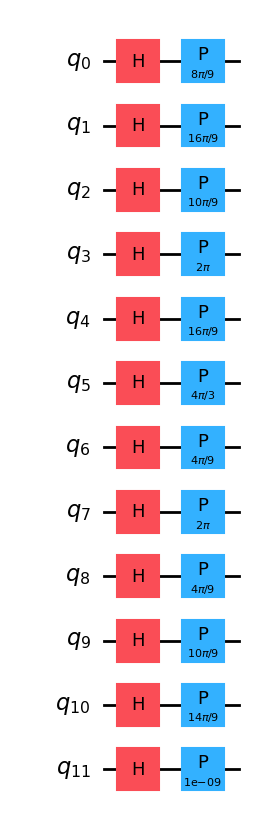

In [14]:
x_vec = [4,8,5,9,8,6,2,9,2,5,7,0]
print(len(x_vec))
print(rescale_vec(x_vec))
phase_encoding(x_vec)

## Dense angle encoding (DAE)

Features:

* combination of angle and phase encoding
* two feature values encoded in a single qubit: one feature with a Y-axis rotation angle, the other feature with a z-axis rotation angle:
\begin{equation}
|\vec{x}_k^{(j)},\vec{x}_l^{(j)}\rangle = R_Z(\phi=\vec{x}_l^{(j)})R_Y(\theta=\vec{x}_k^{(j)})|0\rangle=\cos(\frac{\vec{x}_k^{(j)}}{2})|0\rangle +e^{i\vec{x}_l^{(j)}}\sin(\frac{\vec{x}_k^{(j)}}{2})|1\rangle
\end{equation}
* 2$\times$ reduction in number of qubits required
* to more features this extends to
\begin{equation}
|\vec{x}\rangle = \otimes_{k=1}^{N/2}\cos(x_{2k-1})|0\rangle + e^{ix_{2k}\sin(x_{2k-1})|1\rangle
\end{equation}

Example: Encode the two features $x_1=\theta=3\pi/8$ and $x_2=\phi=7\pi/4$

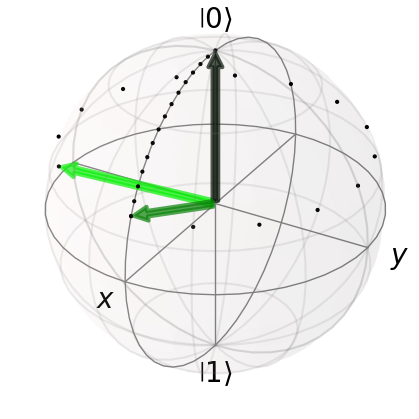

In [15]:
qc = QuantumCircuit(1)
state1 = Statevector.from_instruction(qc)
qc.ry(3 * pi / 8, 0)
state2 = Statevector.from_instruction(qc)
qc.rz(7 * pi / 4, 0)
state3 = Statevector.from_instruction(qc)
states = state1, state2, state3
 
plot_Nstates(states, axis=None, plot_trace_points=True)

As a second example, we take $\vec{x}^{(1)}=(4,8,5,9,8,6,2,9,2,5,7,0,3,7,5)$. Here, we can make us of functions defined before such as the `rescale_vec()` functions, which rescales the values to angles between $(0,2\pi]$

In [16]:
def dense_angle_encoding(vec):
    
    nqubit=math.ceil((len(vec)/2))

    scaled_vec = rescale_vec(vec)
    
    qc = QuantumCircuit(nqubit)

    for nx in range(0,nqubit):
        print(nx,nx+1,nqubit)
        qc.ry(scaled_vec[2*nx], nx)
        if nx+1 != nqubit: qc.rz(scaled_vec[2*nx+1], nx)
        
    return qc.draw("mpl", scale=1)

15
[2.79252680e+00 5.58505361e+00 3.49065850e+00 6.28318531e+00
 5.58505361e+00 4.18879020e+00 1.39626340e+00 6.28318531e+00
 1.39626340e+00 3.49065850e+00 4.88692191e+00 1.00000000e-09
 2.09439510e+00 4.88692191e+00 3.49065850e+00]
0 1 8
1 2 8
2 3 8
3 4 8
4 5 8
5 6 8
6 7 8
7 8 8


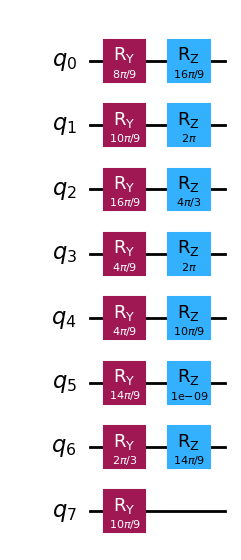

In [17]:
x_vec = [4,8,5,9,8,6,2,9,2,5,7,0,3,7,5]
print(len(x_vec))
print(rescale_vec(x_vec))
dense_angle_encoding(x_vec)

The solution on the IBM website used an additional $R_Z$ with $\phi=0$ for the last qubit.

# Encoding with build-in feature maps

## Encoding at arbitrary points

The encoding methods described before can be grouped into two categories:
* product state preparation: angle encoding, phase encoding, dense encoding, which yield shallower circuits and can store 1 or 2 features on each qubit.
* Entangled states: basis encoding, amplitude encoding, which associate a feature with a state rather than qubit, result in deeper circuits, and store more features per qubit on average.

In the following, we look at encoding that need not to be entirely in product states or entirely in entangled states. In particular, we look in Qiskit's built-in methods that encode $N$ features as rotations on $N$ parametrized gates on $n$ qubits, where $n\leq N$. The reasoning behind the encoding schemes presented in the following is to give consideration to both number of qubits and circuit depth.

### Efficient SU2

Qiskit's `efficient_su2`:

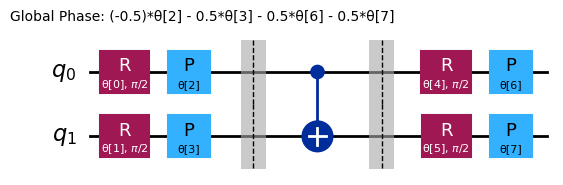

In [18]:
from qiskit.circuit.library import efficient_su2
 
circuit = efficient_su2(num_qubits=2, reps=1, insert_barriers=True)
circuit.decompose().draw(output="mpl")

Written in Qiskit conventions, we start in $|q_1,q_0\rangle = |00\rangle$. Up to the first barrier, we have
\begin{equation}
|\psi_{b1}\rangle = \left(\cos(\frac{\theta_1}{2})|0\rangle + \sin(\frac{\theta_1}{2})e^{i\theta_3}|1\rangle\right)\otimes\left(\cos(\frac{\theta_0}{2})|0\rangle + \sin(\frac{\theta_0}{2})e^{i\theta_2}|1\rangle\right)
\end{equation}
So far, that's just dense encoding as before. Now, after the CNOT gate and second barrier, the state becomes
\begin{align}
|\psi\rangle_{b2} = & \cos\left(\frac{\theta_1}{2}\right)\cos\left(\frac{\theta_0}{2}\right)|00\rangle+\cos\left(\frac{\theta_1}{2}\right)\sin\left(\frac{\theta_0}{2}\right)e^{i\theta_2}|11\rangle\\
+&\sin\left(\frac{\theta_1}{2}\right)\cos\left(\frac{\theta_0}{2}\right)e^{i\theta_3}|10\rangle+\sin\left(\frac{\theta_1}{2}\right)\sin\left(\frac{\theta_0}{2}\right)e^{i\theta_2}e^{i\theta_3}|01\rangle
\end{align}
which blows up after the last set of single-qubit rotations to
\begin{align}
|\psi\rangle_{\text{final}} = &
\left[\cos\left(\frac{\theta_0}{2}\right)\left(\cos\left(\frac{\theta_1}{2}\right)\cos\left(\frac{\theta_5}{2}\right)-\sin\left(\frac{\theta_1}{2}\right)\sin\left(\frac{\theta_5}{2}\right)e^{i\theta_3}\right)\cos\left(\frac{\theta_4}{2}\right)\right.\\
+& \left.\sin\left(\frac{\theta_0}{2}\right)\left(\cos\left(\frac{\theta_1}{2}\right)\sin\left(\frac{\theta_5}{2}\right)-\sin\left(\frac{\theta_1}{2}\right)\cos\left(\frac{\theta_5}{2}\right)e^{i\theta_3}\right)\sin\left(\frac{\theta_4}{2}\right)e^{i\theta_2}\right]
|00\rangle\\
+& \left[\cos\left(\frac{\theta_0}{2}\right)\left(\cos\left(\frac{\theta_1}{2}\right)\cos\left(\frac{\theta_5}{2}\right)-\sin\left(\frac{\theta_1}{2}\right)\sin\left(\frac{\theta_5}{2}\right)e^{i\theta_3}\right)\sin\left(\frac{\theta_4}{2}\right)\right.\\
+&\left.\sin\left(\frac{\theta_0}{2}\right)\left(-\cos\left(\frac{\theta_1}{2}\right)\sin\left(\frac{\theta_5}{2}\right)+\sin\left(\frac{\theta_1}{2}\right)\cos\left(\frac{\theta_5}{2}\right)e^{i\theta_3}\right)\cos\left(\frac{\theta_4}{2}\right)e^{i\theta_2}\right]
e^{i\theta_6}|01\rangle\\
+& \left[\cos\left(\frac{\theta_0}{2}\right)\left(\cos\left(\frac{\theta_1}{2}\right)\sin\left(\frac{\theta_5}{2}\right)+\sin\left(\frac{\theta_1}{2}\right)\cos\left(\frac{\theta_5}{2}\right)e^{i\theta_3}\right)\cos\left(\frac{\theta_4}{2}\right)\right.\\
-&\left.\sin\left(\frac{\theta_0}{2}\right)\left(\cos\left(\frac{\theta_1}{2}\right)\cos\left(\frac{\theta_5}{2}\right)+\sin\left(\frac{\theta_1}{2}\right)\sin\left(\frac{\theta_5}{2}\right)e^{i\theta_3}\right)\sin\left(\frac{\theta_4}{2}\right)e^{i\theta_2}\right]
e^{i\theta_7}|10\rangle\\
+& \left[\cos\left(\frac{\theta_0}{2}\right)\left(\cos\left(\frac{\theta_1}{2}\right)\sin\left(\frac{\theta_5}{2}\right)+\sin\left(\frac{\theta_1}{2}\right)\cos\left(\frac{\theta_5}{2}\right)e^{i\theta_3}\right)\sin\left(\frac{\theta_4}{2}\right)\right.\\
+& \left.\sin\left(\frac{\theta_0}{2}\right)\left(\cos\left(\frac{\theta_1}{2}\right)\cos\left(\frac{\theta_5}{2}\right)+\sin\left(\frac{\theta_1}{2}\right)\sin\left(\frac{\theta_5}{2}\right)e^{i\theta_3}\right)\cos\left(\frac{\theta_4}{2}\right)e^{i\theta_2}\right]
e^{i\theta_6}e^{i\theta_7}|11\rangle
\end{align}
The reason why 8 features can be stored in two qubits is that the coefficient of $2^2=4$ qubit states are complex, meaning every coefficient can have one real and one imaginary argument. Simplified the above state would be written as
\begin{equation}
\psi_\text{final} = (a_0+ib_0)|00\rangle+(a_1+ib_1)|01\rangle+(a_2+ib_2)|10\rangle+(a_3+ib_3)|11\rangle
\end{equation}
The vector $\vec{x} = (0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2)$ with 12 features can be stored on 3 qubits. The corresponding qiskit code is given by

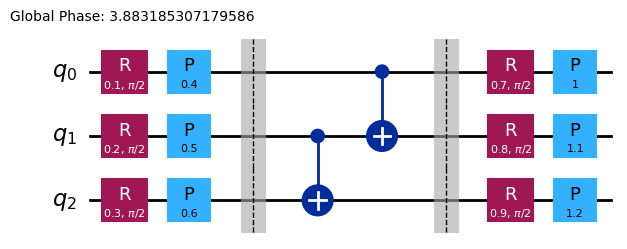

In [19]:
x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
circuit = efficient_su2(num_qubits=3, reps=1, insert_barriers=True)
encode = circuit.assign_parameters(x)
encode.decompose().draw(output="mpl")

### Feature Maps

Encoding data into a quantum circuit is a feature mapping, from the data space to the Hilbert space. The next few encoding methods have it literally in their name.

### $Z$ feature map (ZFM)

ZFM can be seen as a natural extension of phase encoding. It consists of alternating layers of single-qubit gates (Hadamard, phase gates). A data vector $\vec{x}$ with $N$ features will be encoded by a unitary operator acting on the ground state $|0\rangle^{\otimes N}$:
\begin{equation}
\mathscr{U}_{\rm ZFM}(\vec{x})|0\rangle^{\otimes N}=|\phi (\vec{x})\rangle
\end{equation}
It is a one-to-one mapping where $N$ features are mapped onto $N$ qubits. First a layer of Hadamard gates $H^{\otimes n}$ is applied, followed by a phase gate layer $P(\vec{x}_1)\otimes ... \otimes P(\vec{x}_N)$. The full ZFM circuit unitary transformation is
\begin{equation}
\mathscr{U}_{\text{ZFM}}=\big(P(\vec{x}_1)\otimes\ldots P(\vec{x}_k)\otimes\ldots P(\vec{x}_N)H^{\otimes N}\big)=\left(\bigotimes_{k = 1}^N P(\vec{x}_k)\right)H^{\otimes N}
\end{equation}
and after $r$ repetitions
\begin{equation}
\mathscr{U}^{(r)}_{\text{ZFM}}\left(\vec{x}\right)=\prod_{s=1}^{r}\left[\left(\bigotimes_{k = 1}^N P(\vec{x}_k)\right)H^{\otimes N}\right]
\end{equation}
The ZFM feature map state is a product state and is efficient for classical simulation.

As an example, let's take $\vec{x}=(\frac12 \pi, \frac13 \pi)$ which will be transformed to
\begin{equation}
\mathscr{U}_{\text{ZFM}}(\bar{x})|00\rangle = P(\bar{x})^{\otimes 2} H^{\otimes 2}|00\rangle = \left( P\left(\textstyle\frac{1}{3}\pi\right)H|0\rangle \right) \otimes \left(P\left(\textstyle\frac{1}{2}\pi\right)H|0\rangle\right).
\end{equation}
In Qiskit this is realized by

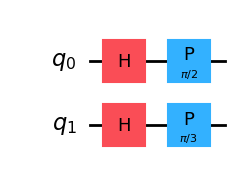

In [21]:
qc0 = QuantumCircuit(1)
qc1 = QuantumCircuit(1)
 
qc0.h(0)
qc0.p(pi / 2, 0)
 
qc1.h(0)
qc1.p(pi / 3, 0)
 
# Combine circuits qc0 and qc1 into 1 circuit
qc = QuantumCircuit(2)
qc.compose(qc0, [0], inplace=True)
qc.compose(qc1, [1], inplace=True)
 
qc.draw("mpl", scale=1)

or with the built-in Qiskit function and three repetitions by

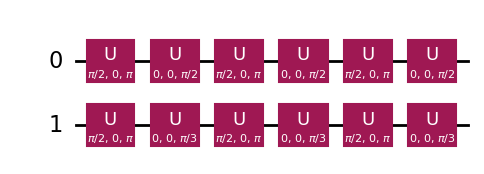

In [22]:
from qiskit.circuit.library import z_feature_map
 
zfeature_map = z_feature_map(feature_dimension=2, reps=3)
zfeature_map = zfeature_map.assign_parameters([(1 / 2) * pi / 2, (1 / 2) * pi / 3])
zfeature_map.decompose().draw("mpl")

where we had to divide the angle by 2 to match the convention $\theta=2\beta$ where \beta is the angle that Qiskit uses. This is a different circuit than the one above, but is consistent. The state vectors are given by

In [24]:
state1 = Statevector.from_instruction(qc)
state1.draw('latex')

<IPython.core.display.Latex object>

In [27]:
state2 = Statevector.from_instruction(zfeature_map)
state2.draw('latex')

<IPython.core.display.Latex object>

### ZZ feature map (ZZFM)

The $ZZ$ feature map extends the ZFM by including the two-qubit entangling $ZZ$-rotation gate $R_{ZZ}(\theta)$ (expensive on classical computers!). $R_{ZZ}$ is maximally entangling for $\theta=]frac12 \pi$ and generally, the degree of entanglement is determined by the encoded feature value. The following Qiskit code shows how $R_{ZZ}$ can be decomposed into a series of two-qubit gates. As an example, we encode a single feature $\vec{x}_k=\pi$.

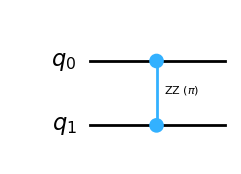

In [28]:
qc = QuantumCircuit(2)
qc.rzz(pi, 0, 1)
qc.draw("mpl", scale=1)

which can be decomposed to

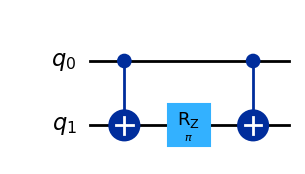

In [29]:
qc.decompose().draw("mpl", scale=1)

The full circle is given by
\begin{equation}
\mathscr{U}_{\text{ZZFM}}(\vec{x}) = U_{ZZ}(\vec{x})\big(P(\vec{x}_1)\otimes\ldots P(\vec{x}_k)\otimes\ldots P(\vec{x}_N)H^{\otimes N}\big)=U_{ZZ}(\vec{x})\left(\bigotimes_{k = 1}^N P(\vec{x}_k)\right)H^{\otimes N},
\end{equation}
where $U_{ZZ}$ contains $ZZ$-gate layer structured by an entanglement scheme with some examples being shown below.

The $R_{ZZ,q,p}(\theta_{q,p})$ gate that encodes $\vec{x}_p$ and $\vec{x}_q$ into qubits $p$ and $q$ will have the argument
\begin{equation}
\theta_{q,p}\to \phi(\vec{x}_q,\vec{x}_p)=2(\pi-\vec{x}_q)(\pi-\vec{x}_p)
\end{equation}
The extension to multiple repetitions is given by
\begin{equation}
\mathscr{U}^{(r)}_{\text{ZZFM}}\left(\vec{x}\right)=\prod_{s=1}^{r}\left[U_{ZZ}(\vec{x})\left(\bigotimes_{k = 1}^N P(\vec{x}_k)\right)H^{\otimes N}\right].
\end{equation}

In Qiskit, data vector with two features is encoded with a two-qubit ZZFM and one repetition using the following code:

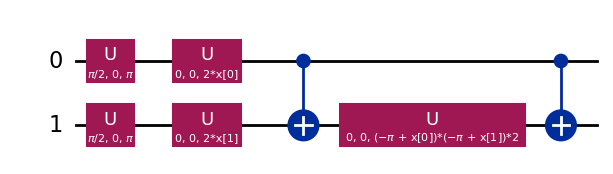

In [30]:
from qiskit.circuit.library import zz_feature_map
 
feature_dim = 2
zzfeature_map = zz_feature_map(
    feature_dimension=feature_dim, entanglement="linear", reps=1
)
zzfeature_map.decompose(reps=1).draw("mpl", scale=1)

and a four-dimensional data vector:

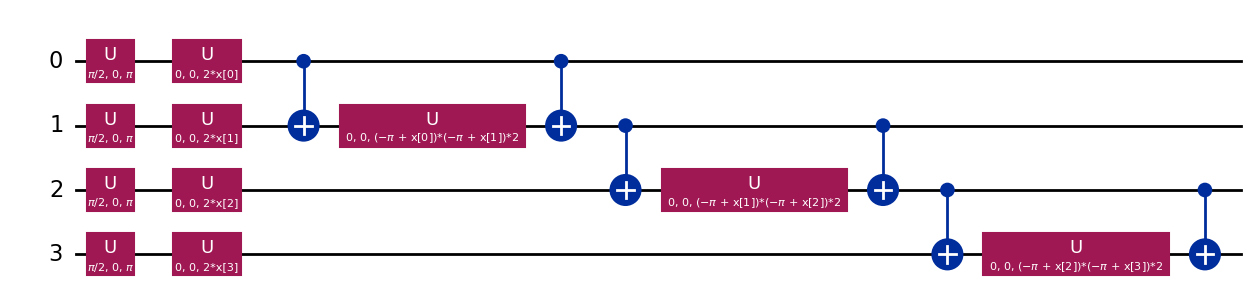

In [31]:
feature_dim = 4
zzfeature_map = zz_feature_map(
    feature_dimension=feature_dim, entanglement="linear", reps=1
)
zzfeature_map.decompose().draw("mpl", scale=1)

Alternative built-in entanglement schemes include `circular` and `full`.

### Pauli feature map (PFM)

The PFM uses arbitrary Pauli gates and is a generalization of the FZM and ZZFM. For $r$ repetitions and encoding $N$ features, it has the form
\begin{equation}
\mathscr{U}_{\text{PFM}}(\vec{x}) = \prod_{s=1}^{r} U(\vec{x}) H^{\otimes n}.
\end{equation}
with the operator
\begin{equation}
U(\vec{x}) = \exp\left(i \sum_{S \in\mathcal{I}} \phi_S(\vec{x}) \prod_{i \in S} \sigma_i \right),
\end{equation}
where $\phi_S$ is generally defined as
\begin{equation}
\phi_S(\vec{x})=
    \begin{cases}
      x_i & \text{if } S= \{i\} \text{ (single-qubit)}\\
      \prod_{j\in{S}}(\pi-x_j) & \text{if } |S|\ge2 \text{ (multi-qubit)}\\
    \end{cases}
\end{equation}
Here $\mathcal{I}$ is the set of all qubit connectivities as determined by the feature map, like $\{\{0\},\{2,3\}\}$ if a single qubit gate acted on qubit 0, and a two-qubit gate acted on qubits 2 and 3. In the Qiskit `Pauli feature map`, the Pauli operator $\sigma_i$ can be chosen freely between $I, X, Y, Z$. In the following case, we choose $Y$ for single-qubit gates, and $XX$ for two-qubit gates. The `linear` entanglement scheme means that only nearest-neighbours are entangled

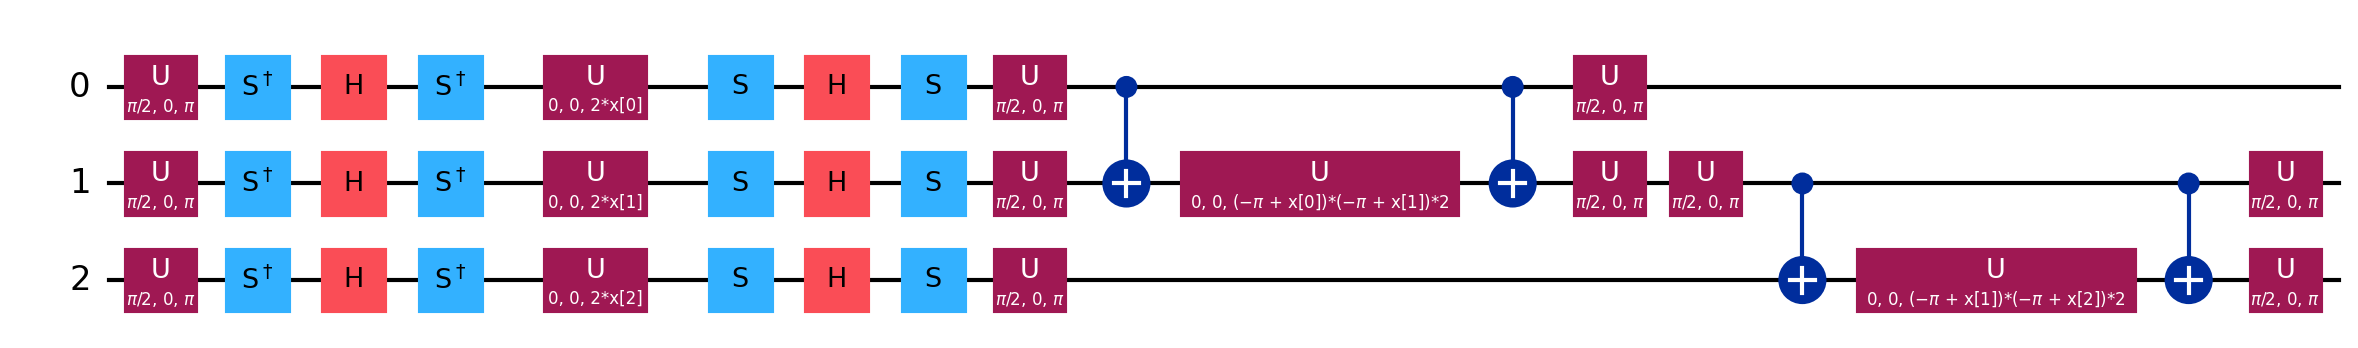

In [32]:
from qiskit.circuit.library import pauli_feature_map
 
feature_dim = 3
pfmap = pauli_feature_map(
    feature_dimension=feature_dim, entanglement="linear", reps=1, paulis=["Y", "XX"]
)
 
pfmap.decompose().draw("mpl", scale=1.5)

### Gallery of Pauli feature maps

Here is a visualisation of various Pauli feature maps for two-qubit circuits to get a better picture of  the range of possibilities

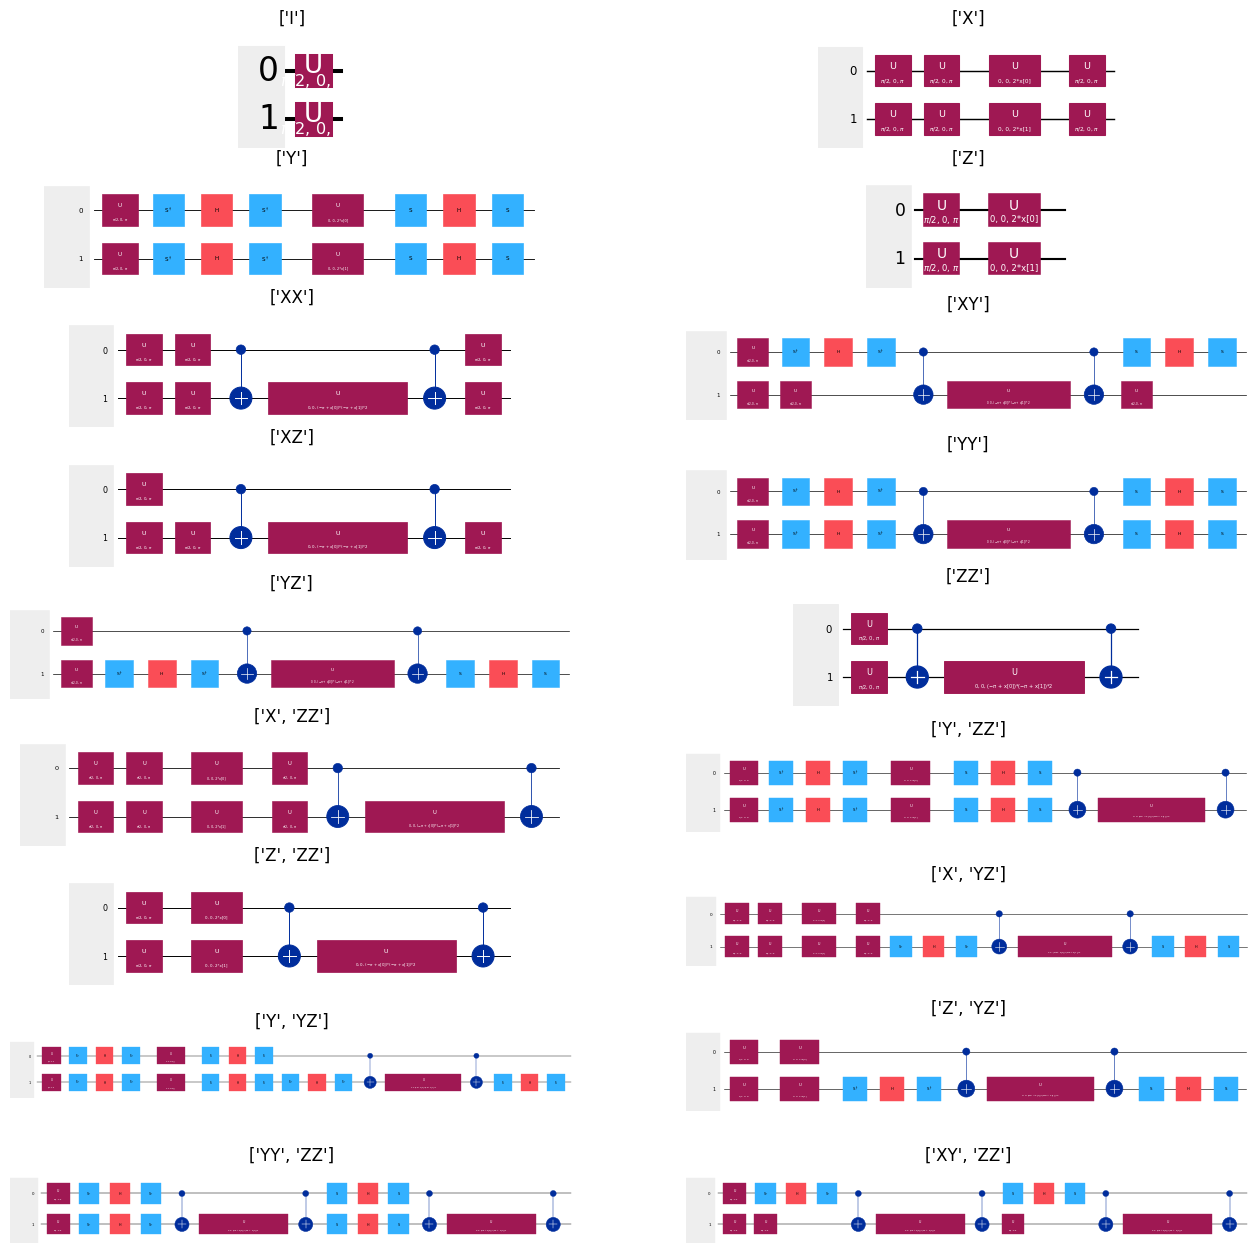

In [33]:
from qiskit.visualization import circuit_drawer
import matplotlib.pyplot as plt
 
feature_dim = 2
fig, axs = plt.subplots(9, 2)
i_plot = 0
for paulis in [
    ["I"],
    ["X"],
    ["Y"],
    ["Z"],
    ["XX"],
    ["XY"],
    ["XZ"],
    ["YY"],
    ["YZ"],
    ["ZZ"],
    ["X", "ZZ"],
    ["Y", "ZZ"],
    ["Z", "ZZ"],
    ["X", "YZ"],
    ["Y", "YZ"],
    ["Z", "YZ"],
    ["YY", "ZZ"],
    ["XY", "ZZ"],
]:
    pfmap = pauli_feature_map(feature_dimension=feature_dim, paulis=paulis, reps=1)
    circuit_drawer(
        pfmap.decompose(),
        output="mpl",
        style={"backgroundcolor": "#EEEEEE"},
        ax=axs[int((i_plot - i_plot % 2) / 2), i_plot % 2],
    )
    axs[int((i_plot - i_plot % 2) / 2), i_plot % 2].title.set_text(paulis)
    i_plot += 1
 
fig.set_figheight(16)
fig.set_figwidth(16)

Below, we compare several encoding schemes and plot the counts of all gates needed for a certain number of data features.

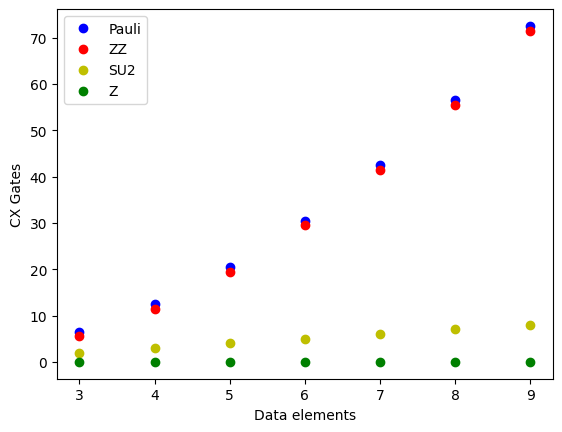

In [34]:
# Initializing parameters and empty lists for depths
x = [0.1, 0.2]
n_data = []
zz2gates = []
su22gates = []
z2gates = []
p2gates = []
 
# Generating feature maps
for n in range(3, 10):
    x.append(n / 10)
    zzcircuit = zz_feature_map(n, reps=1, insert_barriers=True)
    zcircuit = z_feature_map(n, reps=1, insert_barriers=True)
    su2circuit = efficient_su2(n, reps=1, insert_barriers=True)
    pcircuit = pauli_feature_map(n, reps=1, paulis=["XX"], insert_barriers=True)
    # Getting the cx depths
    zzcx = zzcircuit.decompose().count_ops().get("cx")
    zcx = zcircuit.decompose().count_ops().get("cx")
    su2cx = su2circuit.decompose().count_ops().get("cx")
    pcx = pcircuit.decompose().count_ops().get("cx")
 
    # Appending the cx gate counts to the lists. We shift the zz and pauli data points, because they overlap.
    n_data.append(n)
    zz2gates.append(zzcx - 0.5)
    z2gates.append(0)
    su22gates.append(su2cx)
    p2gates.append(pcx + 0.5)
 
# Plot the output
plt.plot(n_data, p2gates, "bo")
plt.plot(n_data, zz2gates, "ro")
plt.plot(n_data, su22gates, "yo")
plt.plot(n_data, z2gates, "go")
plt.ylabel("CX Gates")
plt.xlabel("Data elements")
plt.legend(["Pauli", "ZZ", "SU2", "Z"])
# plt.suptitle('zz_feature_map(n)')
plt.show()

## Hardware-efficient feature mapping

Hardware-efficient feature mapping takes into account constraints of real quantum computers, in the interest of reducing noise and errors in the computation.

Hardware efficiency strategies are:
* minimization of the depth of the quantum circuit, so noise and decoherence have less time to corrupt computation. Depth is the number of time-aligned gate steps
* Transpilation: process of converting from high-level abstraction to one ready ro run on a real quantum computer. All gates have to be transpiled into the set of native hardware gates. For example, `ibm_torino` has `{CZ, ID, RZ, SX, X}` as native gates.

In Qiskit, the `optimization` argument of the transpiler can be set from 0 to the highest level of 3. The transpiler pipeline can be managed with the Qiskit Pass Manager, and Transpiler.